## Libs

In [1]:
import os
import shutil
from sklearn.model_selection import train_test_split

In [2]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [3]:
import matplotlib.pyplot as plt
import numpy as np

## Train test split

In [4]:
# Définition des transformations de base pour l'ensemble d'entraînement
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

# Pour l'ensemble de test, nous pourrions ne pas avoir besoin d'augmentation des données
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
train_data = datasets.ImageFolder(root='data/train', transform=train_transform)
test_data = datasets.ImageFolder(root='data/test', transform=test_transform)


In [6]:
from PIL import Image

image = Image.open("data/train/green_area/Forest_1419.jpg")
print(image.mode)

RGB


In [7]:
classes = ["cloudy","desert","green_area","water"]

## Choix du modèle

In [8]:
batch_size = 32

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [9]:
class LeNet(nn.Module):
    def __init__(self, num_classes=4): 
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 29 * 29, 120)  
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 29 * 29)  
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [10]:
# Définition du modèle
model = LeNet(num_classes=4) 
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)  # lr est le taux d'apprentissage

In [11]:
num_epochs = 5

# Boucle d'entraînement
for epoch in range(num_epochs):
    for inputs, labels in train_loader:  
        optimizer.zero_grad()  # Remettre les gradients à zéro
        
        # Forward pass
        outputs = model(inputs)
        
        # Calcul de la perte
        loss = criterion(outputs, labels)
        
        # Backward pass et optimisation
        loss.backward()  # Rétropropagation
        optimizer.step()  # Mise à jour des poids

In [12]:
# Évaluation
model.eval()  # Met le modèle en mode évaluation
with torch.no_grad():  # Pas besoin de calculer les gradients
    for inputs, labels in test_loader:
        outputs = model(inputs)
        test_loss = criterion(outputs, labels)


In [13]:
correct = 0
total = 0
with torch.no_grad():  # Pas besoin de calculer les gradients
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy du modèle sur l\'ensemble de test: {100 * correct // total}%')

Accuracy du modèle sur l'ensemble de test: 75%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


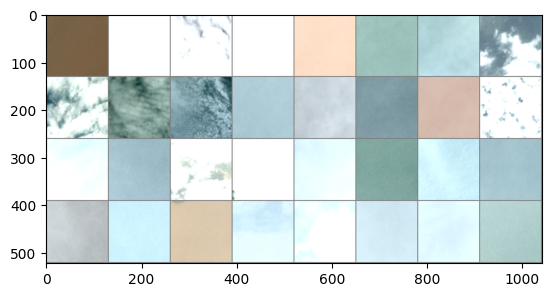

Vraies étiquettes:  cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy
Prédictions:  desert cloudy cloudy cloudy desert cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy desert cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy desert cloudy cloudy cloudy cloudy cloudy


In [14]:
def imshow(img):
    img = img / 2 + 0.5  # dénormaliser
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()

# Charger quelques images de test
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Afficher les images
imshow(torchvision.utils.make_grid(images))
print('Vraies étiquettes: ', ' '.join(f'{classes[labels[j]]}' for j in range(batch_size)))

# Prédire les classes
outputs = model(images)
_, predicted = torch.max(outputs, 1)

print('Prédictions: ', ' '.join(f'{classes[predicted[j]]}' for j in range(batch_size)))


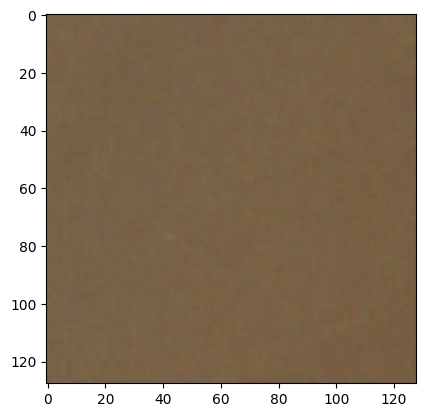

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Vraie étiquette: cloudy, Prédiction: desert


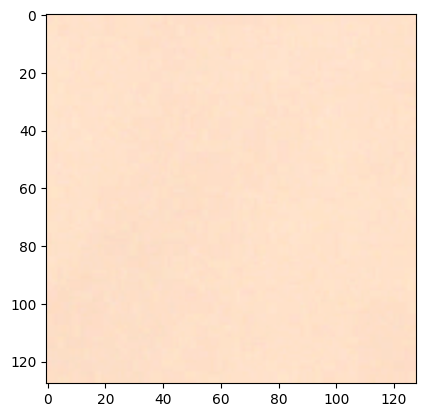

Vraie étiquette: cloudy, Prédiction: desert


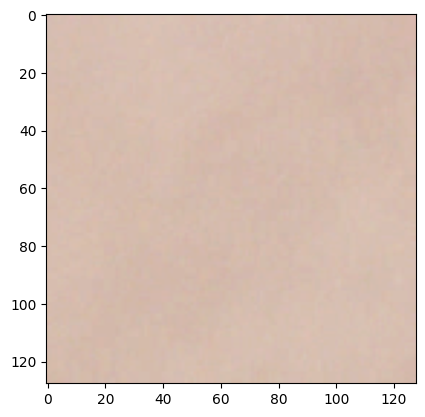

Vraie étiquette: cloudy, Prédiction: desert


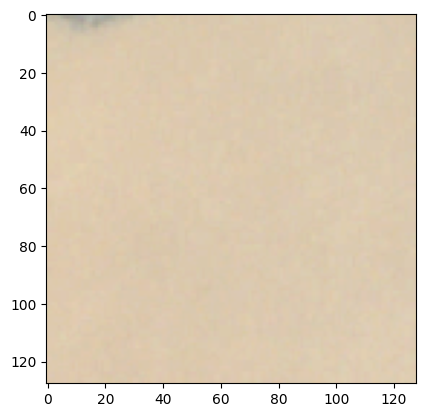

Vraie étiquette: cloudy, Prédiction: desert


In [15]:
incorrect_indices = [i for i, (real, pred) in enumerate(zip(labels, predicted)) if real != pred]

# Afficher les images mal prédites
for i in incorrect_indices:
    imshow(images[i])
    print(f'Vraie étiquette: {classes[labels[i]]}, Prédiction: {classes[predicted[i]]}')
